<a href="https://colab.research.google.com/github/BanuB/DATA608FALL2022/blob/main/Module2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

# from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

"The steps involved in datashading are (1) create a Canvas object with the shape of the eventual plot (i.e. having one storage bin for collecting points, per final pixel), (2) aggregating all points into that set of bins, incrementally counting them, and (3) mapping the resulting counts into a visible color from a specified range to make an image:"

# New Section

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [80]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)


ny = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/pluto_22v2.csv')


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (21,22,24,26,28) have mixed types.Specify dtype option on import or set low_memory=False.



In [81]:
ny.head()

borough  block  lot     cd    bct2020     bctcb2020  ct2010  cb2010  \
0      SI   1597  125  502.0  5029104.0  5.029104e+10  291.04  3007.0   
2      BK   4794    1  309.0  3080600.0  3.080600e+10  806.00  2000.0   
3      BK   1488  105  303.0  3037500.0  3.037500e+10  375.00  1001.0   
4      BK   4794   17  309.0  3080600.0  3.080600e+10  806.00  2000.0   
5      BK   4794   78  309.0  3080600.0  3.080600e+10  806.00  2000.0   

   schooldist  council  ...        appbbl     appdate  plutomapid  \
0        31.0     50.0  ...           NaN         NaN           1   
2        17.0     41.0  ...  3.047940e+09  08/12/2005           1   
3        16.0     41.0  ...  3.014880e+09  11/04/1992           1   
4        17.0     41.0  ...           NaN         NaN           1   
5        17.0     41.0  ...  3.047940e+09  04/11/2006           1   

   firm07_flag  pfirm15_flag  version  dcpedited   latitude  longitude notes  
0          NaN           NaN     22v2        NaN  40.611140 -74.164376   NaN  
2          NaN           NaN     22v2        NaN  40.661794 -73.942532   NaN  
3          NaN           NaN     22v2        NaN  40.686484 -73.920169   NaN  
4          NaN           NaN     22v2        NaN  40.661859 -73.941991   NaN  
5          NaN           NaN     22v2        NaN  40.661517 -73.942539   NaN  

[5 rows x 92 columns]

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [7]:


# wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
# nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
# ny['xcoord'] = 0.3048*ny['xcoord']
# ny['ycoord'] = 0.3048*ny['ycoord']
# ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

# ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [82]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.FigureWidget(data = [trace], layout = layout)

fig

FigureWidget({
    'data': [{'type': 'scatter',
              'uid': 'e10e5dad-aaea-4bc1-95e1-124cf130fcab',
 …

In [9]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

ANSWER:  I am finding it difficult to understand the binning process, so I will have to try that separately and resubmit the code.

In [133]:
ny.dtypes
ny.describe()
ny.corr()

block            lot             cd       bct2020  \
count  812064.000000  812064.000000  811927.000000  8.119270e+05   
mean     5331.171722     143.208248     355.087314  3.515696e+06   
std      3673.102230     795.604549      99.596931  1.014264e+06   
min         1.000000       1.000000     101.000000  1.000100e+06   
25%      2370.000000      19.000000     307.000000  3.028200e+06   
50%      4869.000000      39.000000     402.000000  4.007300e+06   
75%      7512.000000      64.000000     412.000000  4.088400e+06   
max     99999.000000    9450.000000     595.000000  5.990100e+06   

          bctcb2020         ct2010         cb2010     schooldist  \
count  8.119270e+05  811927.000000  811927.000000  811873.000000   
mean   3.515696e+10     466.291713    2055.509338      22.112963   
std    1.014264e+10     377.355160    1153.336583       7.891565   
min    1.000100e+10       1.000000       1.000000       1.000000   
25%    3.028200e+10     170.070000    1004.000000      17.000000   
50%    4.007300e+10     358.000000    2001.000000      24.000000   
75%    4.088401e+10     664.000000    3000.000000      29.000000   
max    5.990100e+10    9901.000000    9003.000000      32.000000   

             council        zipcode  ...        xcoord         ycoord  \
count  811927.000000  811863.000000  ...  8.119150e+05  811915.000000   
mean       32.141673   11019.991231  ...  1.006353e+06  191360.103553   
std        13.149026     466.856065  ...  3.253896e+04   30510.307119   
min         1.000000   10001.000000  ...  9.131640e+05  120966.000000   
25%        23.000000   10466.000000  ...  9.896780e+05  168062.000000   
50%        32.000000   11222.000000  ...  1.009042e+06  189088.000000   
75%        44.000000   11370.000000  ...  1.029512e+06  210833.000000   
max        51.000000   12345.000000  ...  1.067279e+06  272275.000000   

              taxmap        appbbl     plutomapid  firm07_flag  pfirm15_flag  \
count  811755.000000  8.816500e+04  812064.000000      26466.0       55917.0   
mean    36761.020523  3.747594e+09       1.000293          1.0           1.0   
std     10732.426129  1.216116e+09       0.020818          0.0           0.0   
min         1.000000  1.000010e+09       1.000000          1.0           1.0   
25%     31105.000000  3.023830e+09       1.000000          1.0           1.0   
50%     40602.000000  4.049560e+09       1.000000          1.0           1.0   
75%     44602.000000  5.021620e+09       1.000000          1.0           1.0   
max     53203.000000  5.080490e+09       4.000000          1.0           1.0   

            latitude      longitude  notes  
count  811915.000000  811915.000000    0.0  
mean       40.691828     -73.920210    NaN  
std         0.083734       0.117301    NaN  
min        40.498445     -74.255628    NaN  
25%        40.627946     -73.980437    NaN  
50%        40.685589     -73.910572    NaN  
75%        40.745247     -73.836626    NaN  
max        40.913967     -73.700381    NaN  

[8 rows x 64 columns]

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

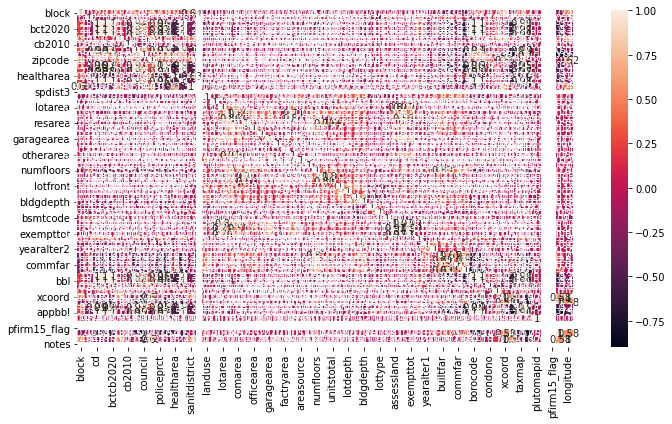

In [137]:

ny.corr()

fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(ny.corr(), 
            annot=True, 
            ax=ax)

plt.tight_layout()


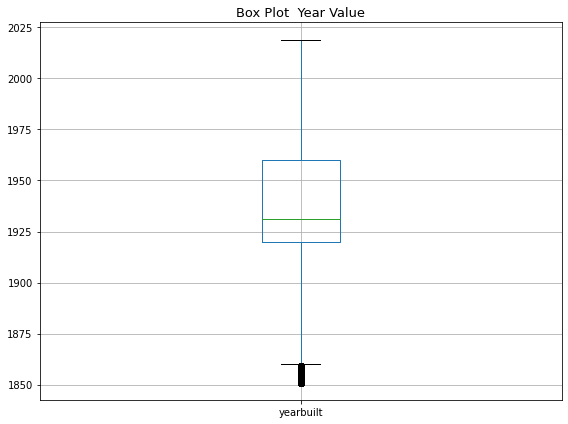

In [139]:
ny.boxplot(column=['yearbuilt'], figsize=(8,6))
plt.title('Box Plot  Year Value', fontsize=13)

plt.tight_layout()

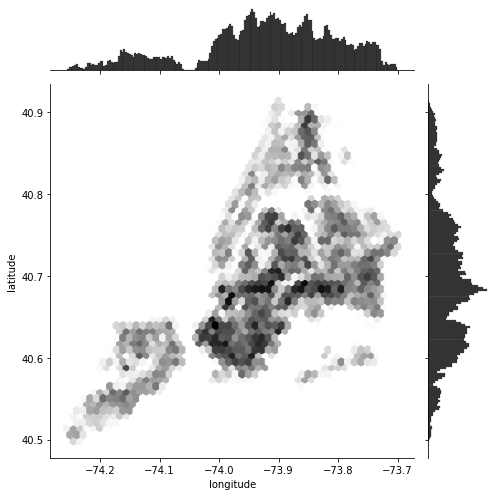

In [145]:
sns.jointplot(x='longitude',
              y='latitude', 
              data=ny,
              kind="hex", 
              color="k", 
              height=7) 

plt.tight_layout()

In [149]:
table = pd.pivot_table(ny, 
                       values='numfloors', 
                       index=['yearbuilt'], 
                       columns=['borough'], 
                       aggfunc=pd.Series.nunique)

table = table.rename(columns={'numfloors': 'count'})
table.index = table.index.astype('int64')
table.index = pd.to_datetime(table.index, format='%Y')

print(table.index.dtype)
table.head(1000)

datetime64[ns]


borough       BK    BX    MN    QN   SI
yearbuilt                              
1851-01-01   6.0   NaN   7.0   NaN  NaN
1852-01-01   8.0   NaN   8.0   NaN  NaN
1853-01-01   7.0   3.0   8.0   NaN  1.0
1854-01-01   8.0   NaN   8.0   NaN  NaN
1855-01-01   6.0   NaN   7.0   NaN  1.0
...          ...   ...   ...   ...  ...
2015-01-01  32.0  16.0  41.0  38.0  6.0
2016-01-01  31.0  17.0  34.0  29.0  7.0
2017-01-01  36.0  18.0  40.0  25.0  8.0
2018-01-01  27.0  18.0  32.0  24.0  7.0
2019-01-01  36.0  21.0  29.0  24.0  7.0

[169 rows x 5 columns]

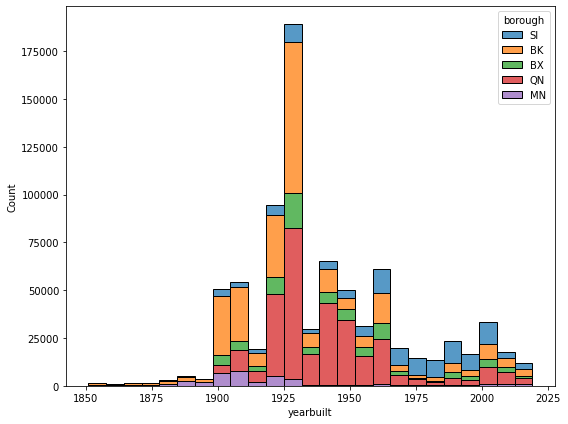

In [142]:
fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(data=ny, 
             x='yearbuilt',
             bins=25,
             hue='borough',
             multiple="stack",
             ax=ax)

plt.tight_layout()

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [83]:
fig = go.FigureWidget(
    data = [
        go.Histogram2d(x=ny['yearbuilt'], y=ny['numfloors'], autobiny=False, ybins={'size': 1}, colorscale='Greens')
    ]
)

fig

FigureWidget({
    'data': [{'autobiny': False,
              'colorscale': [[0.0, 'rgb(247,252,245)'], [0.125…

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



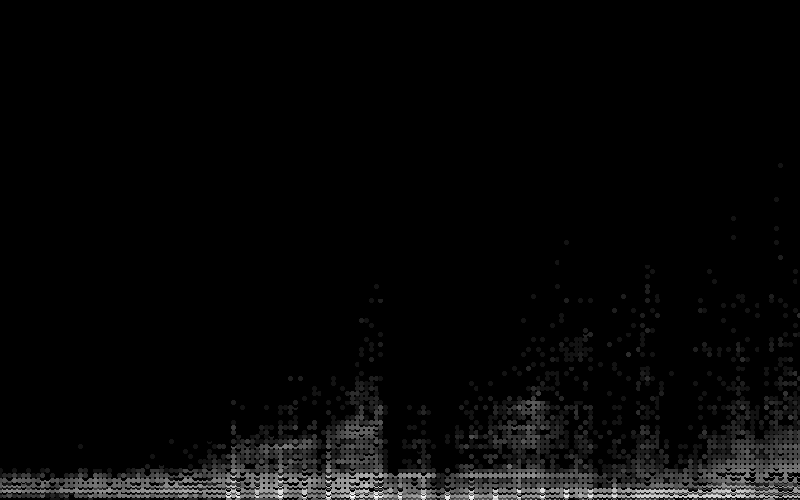

In [84]:
#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

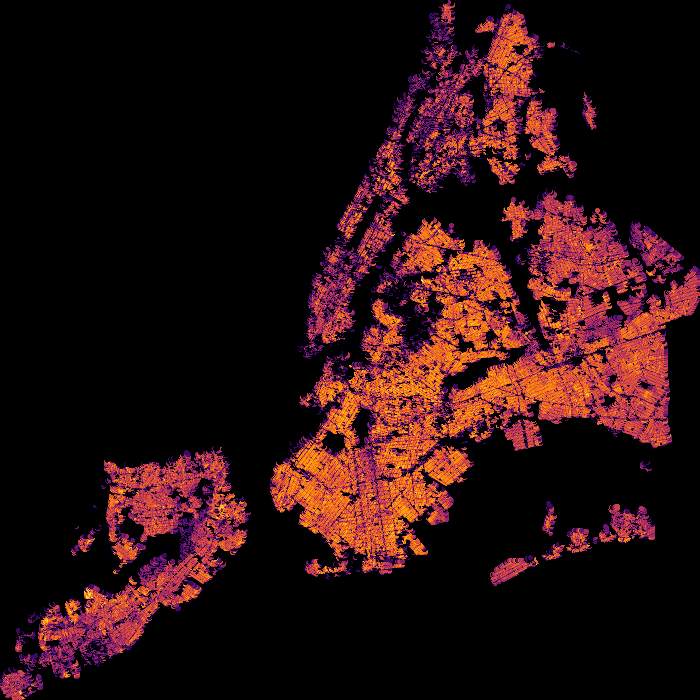

In [85]:
NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')



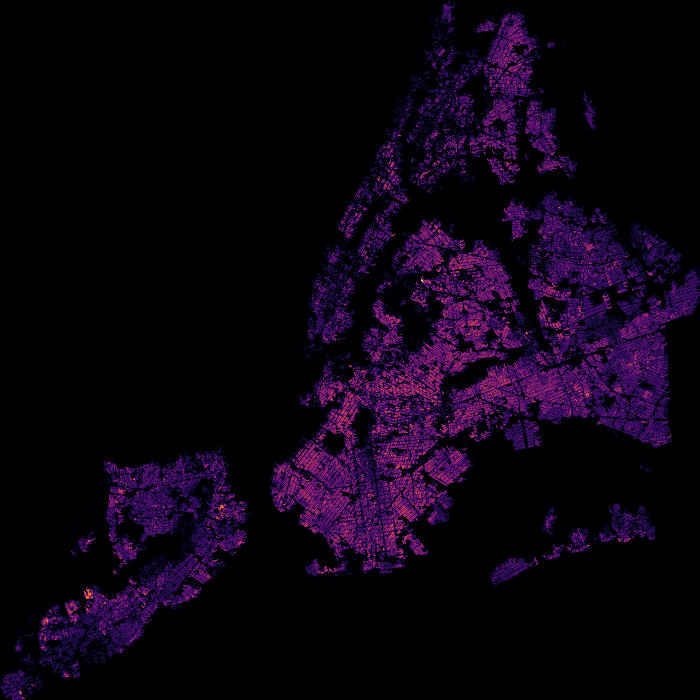

In [86]:


NewYorkCity   = (( 913164.0,  1067279.0), (120966.0, 272275.0))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'xcoord', 'ycoord')
view = tf.shade(agg, cmap = cm(inferno), how='linear')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

ANSWER: Need more time on bivariate choloropeth maps. I tried my best to understand the data. We can see C3 class is largely (both variables as high) on classification and we can see MANHATTAN and BROOKLYN classified with C3 classification. 

TEXT FROM DATA DICTIONARY FOR ANALYSIS



*  01 One & Two Family Buildings
*  02 Multi-Family Walk-Up Buildings
*  03 Multi-Family Elevator Buildings

*  04 Mixed Residential & Commercial Buildings
*  05 Commercial & Office Buildings
*  06 Industrial & Manufacturing


*  07 Transportation & Utility
*  08 Public Facilities & Institutions
*  09 Open Space & Outdoor Recreation
*  10 Parking Facilities
*  11 Vacant Land



Showing the agreement between two variables is also why the number of classes in a bivariate choropleth is larger than the combined sum of classes in each variable alone. In general, if the individual variables have n classes, the bivariate choropleth map will have n2 classes.

In [125]:
# aarray_like
# Input array or object that can be converted to an array.

# qarray_like of float
# Percentile or sequence of percentiles to compute, which must be between 0 and 100 inclusive.

# axis{int, tuple of int, None}, optional
# Axis or axes along which the percentiles are computed. The default is to compute the percentile(s) along a flattened version of the array.

ny1b = ny[['assesstot', 'assessland','longitude','latitude','zipcode','borough','bldgclass','landuse']].copy() 
ny1a = ny[['assesstot', 'assessland','longitude','latitude','borough','landuse']].copy() 
ny1a['StructValue'] = ny1a['assesstot'].sub(ny1a['assessland'], axis=0)
labels = [['A', 'B', 'C'], ['1', '2', '3']] # create class to map to color
p = 100 / len(labels[0]) 
q = np.percentile(ny1a[['assessland', 'StructValue']], [p, 100 - p], axis=0) 
ny1a['Var1'] = pd.cut(ny1a['assessland'], [0, q[0][0], q[1][0], np.inf], right=False, labels=labels[0]) 
ny1a['Var2'] = pd.cut(ny1a['StructValue'], [0, q[0][1], q[1][1], np.inf], right=False, labels=labels[1]) 
ny1a['Bivariate'] = ny1a['Var1'].astype(str) + ny1a['Var2'].astype(str)
ny1a['Bivariate'] = pd.Categorical(ny1a['Bivariate'])
ny1a.head()
ny1b.head()

assesstot  assessland  longitude   latitude  zipcode borough bldgclass  \
0    56580.0     10560.0 -74.164376  40.611140  10314.0      SI        B2   
2   316800.0      8100.0 -73.942532  40.661794  11203.0      BK        S9   
3    58020.0     17280.0 -73.920169  40.686484  11221.0      BK        B2   
4    66420.0     20040.0 -73.941991  40.661859  11203.0      BK        C0   
5    99000.0     20520.0 -73.942539  40.661517  11225.0      BK        C0   

   landuse  
0      1.0  
2      4.0  
3      1.0  
4      2.0  
5      2.0

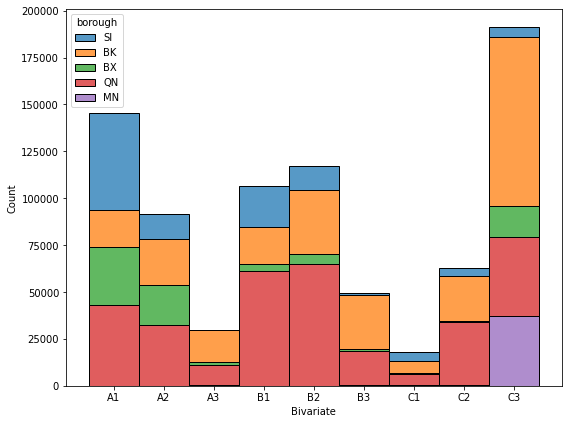

In [144]:
fig, ax = plt.subplots(figsize=(8,6))

sns.histplot(data=ny1a, 
             x='Bivariate',
             bins=25,
             hue='borough',
             multiple="stack",
             ax=ax)

plt.tight_layout()

In [89]:
my_list = ny.columns.values.tolist()

print (my_list)
print (type(my_list))

my_list = ny.columns.values.tolist()





['borough', 'block', 'lot', 'cd', 'bct2020', 'bctcb2020', 'ct2010', 'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct', 'healthcenterdistrict', 'healtharea', 'sanitboro', 'sanitdistrict', 'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'bbl', 'condono', 'tract2010', 'xcoord', 'ycoord', 'zonemap', 'zmcode', 'sanborn', 'taxmap', 'edesignum', 'ap

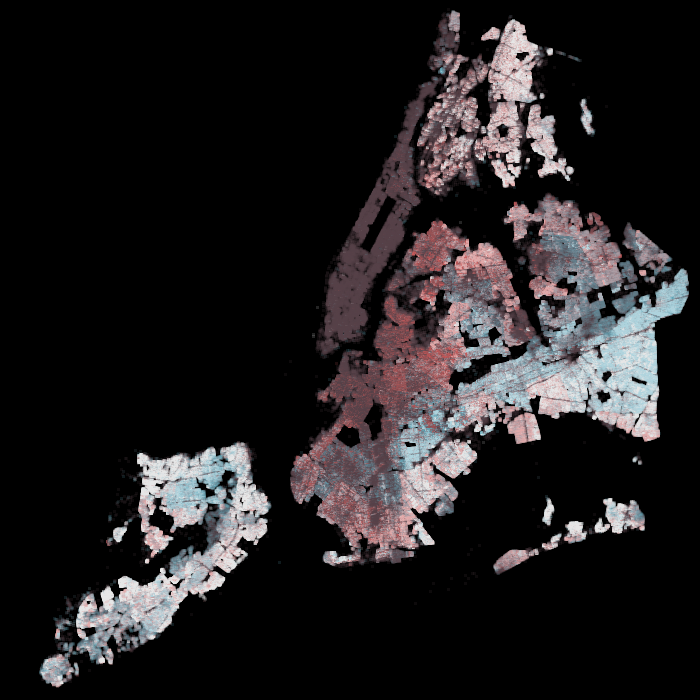

In [114]:


# #'teal-red':    ['#e8e8e8', '#e4acac', '#c85a5a', '#b0d5df', '#ad9ea5', '#985356', '#64acbe', '#627f8c', '#574249'],
colors = {'A1': '#e8e8e8', 'A2': '#e4acac', 'A3': '#c85a5a', 
          'B1': '#b0d5df', 'B2': '#ad9ea5', 'B3': '#985356', 
          'C1': '#64acbe', 'C2': '#627f8c', 'C3': '#574249'}

NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny1a, 'longitude', 'latitude', ds.count_cat('Bivariate'))
view = tf.shade(agg, color_key = colors)
export(tf.spread(view, px=1), 'cloropleth')

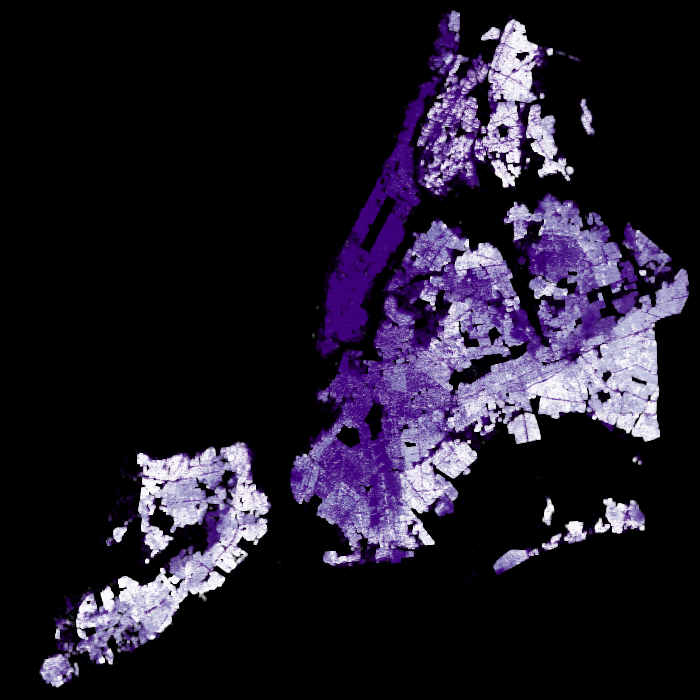

In [91]:
colors = {'A1': '#fcfbfd', 'A2': '#efedf5', 'A3': '#dadaeb', 
          'B1': '#bcbddc', 'B2': '#9e9ac8', 'B3': '#807dba', 
          'C1': '#6a51a3', 'C2': '#54278f', 'C3': '#3f007d'}


NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny1a, 'longitude', 'latitude', ds.count_cat('Bivariate'))
view = tf.shade(agg, color_key = colors)
export(tf.spread(view, px=1), 'cloropleth')

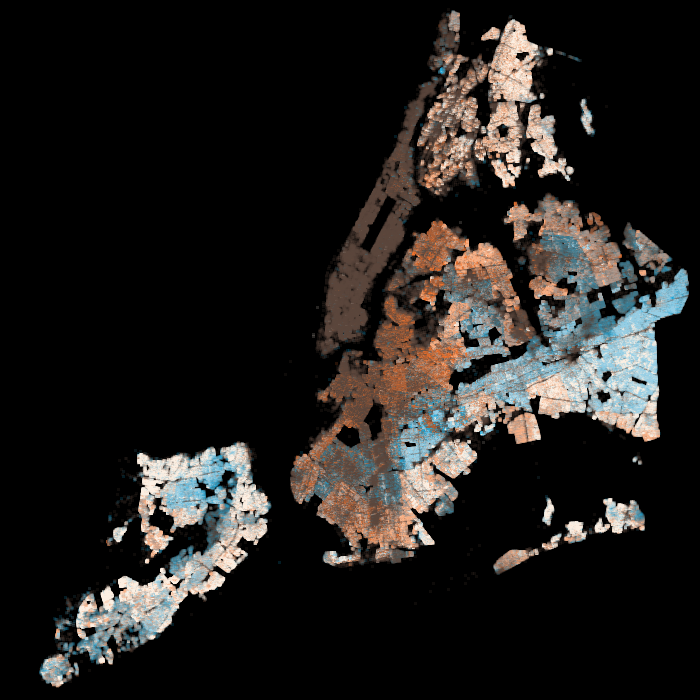

In [92]:

# 'blue-organe': ['#fef1e4', '#fab186', '#f3742d',  '#97d0e7', '#b0988c', '#ab5f37', '#18aee5', '#407b8f', '#5c473d']

colors = {'A1': '#fef1e4', 'A2': '#fab186', 'A3': '#f3742d', 
          'B1': '#97d0e7', 'B2': '#b0988c', 'B3': '#ab5f37', 
          'C1': '#18aee5', 'C2': '#407b8f', 'C3': '#5c473d'}


NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny1a, 'longitude', 'latitude', ds.count_cat('Bivariate'))
view = tf.shade(agg, color_key = colors)
export(tf.spread(view, px=1), 'cloropleth')

In [107]:
ny1b.head()

assesstot  assessland  longitude   latitude  zipcode borough bldgclass  \
0    56580.0     10560.0 -74.164376  40.611140  10314.0      SI        B2   
2   316800.0      8100.0 -73.942532  40.661794  11203.0      BK        S9   
3    58020.0     17280.0 -73.920169  40.686484  11221.0      BK        B2   
4    66420.0     20040.0 -73.941991  40.661859  11203.0      BK        C0   
5    99000.0     20520.0 -73.942539  40.661517  11225.0      BK        C0   

   landuse  
0      1.0  
2      4.0  
3      1.0  
4      2.0  
5      2.0

ColorSchemes image

# 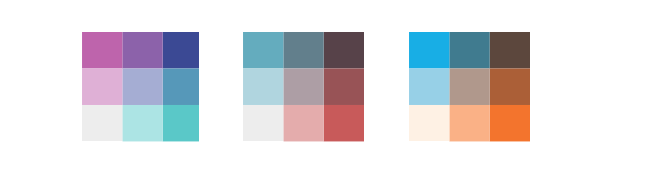

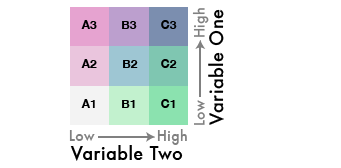